<a href="https://colab.research.google.com/github/wooohoooo/Thompson-Sampling-Examples/blob/master/Handmade_Bandit_solvers_Linear_Context_Logistic_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# getting ready 

In [0]:
#maths
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
import random
from fastprogress.fastprogress import master_bar, progress_bar
from scipy.optimize import minimize

random.seed(4122)
np.random.seed(4122)

In [2]:
#pretty things

matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

width = "16" #@param [16,8,25]
height = "4.5" #@param [4.5, 9,16,8,25]
width = int(width)
height = float(height)


plt.rcParams['figure.figsize'] = width,height


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#set some parameters

# number of features
num_features = "1" #@param [1, 2,3,50]
num_features = int(num_features)

# data size
num_data = "1000" #@param[25,100, 1000,10000]
num_data = int(num_data)


# slopes of reward depending for arm 1 and arm 2
theta1 = 1.6
theta2 = 0.4
theta = [float(theta1), float(theta2)]

# noise in the data
noise = "1" #@param [0.0, 0.1, 0.5, 1,5,10,100]
noise = float(noise)


# scale of uncertainty
v = "50"#@param [1,10, 50, 100, 1000]

v = int(v)


# number of hidden units to use
num_hidden_units = "2" #@param[1,2,10,100]
num_hidden_units = int(num_hidden_units)


This was borrowed from the fantastic https://gdmarmerola.github.io/ts-for-contextual-bandits/ and adapted to fit our simplified API.
Next time, when we talk about nonlinear MABs, I'll do it myself again, but that post is just too good to try to surpass.

In [4]:
X = np.linspace(-6, 6, num_data)
theta

[1.6, 0.4]

In [5]:
X[:10]

array([-6.        , -5.98798799, -5.97597598, -5.96396396, -5.95195195,
       -5.93993994, -5.92792793, -5.91591592, -5.9039039 , -5.89189189])

In [0]:
def customer_reaction(context, arm, theta = theta, noise=noise):

  y = theta[arm] * context
  p = 1/(1+np.exp(-y))

  return np.random.choice([0,1],p=[1-p,p]), max(theta) - p, p


In [7]:
customer_reaction(context = 10, arm = 1)

(1, 0.6179862099620916, 0.9820137900379085)

In [8]:
X[0]

-6.0

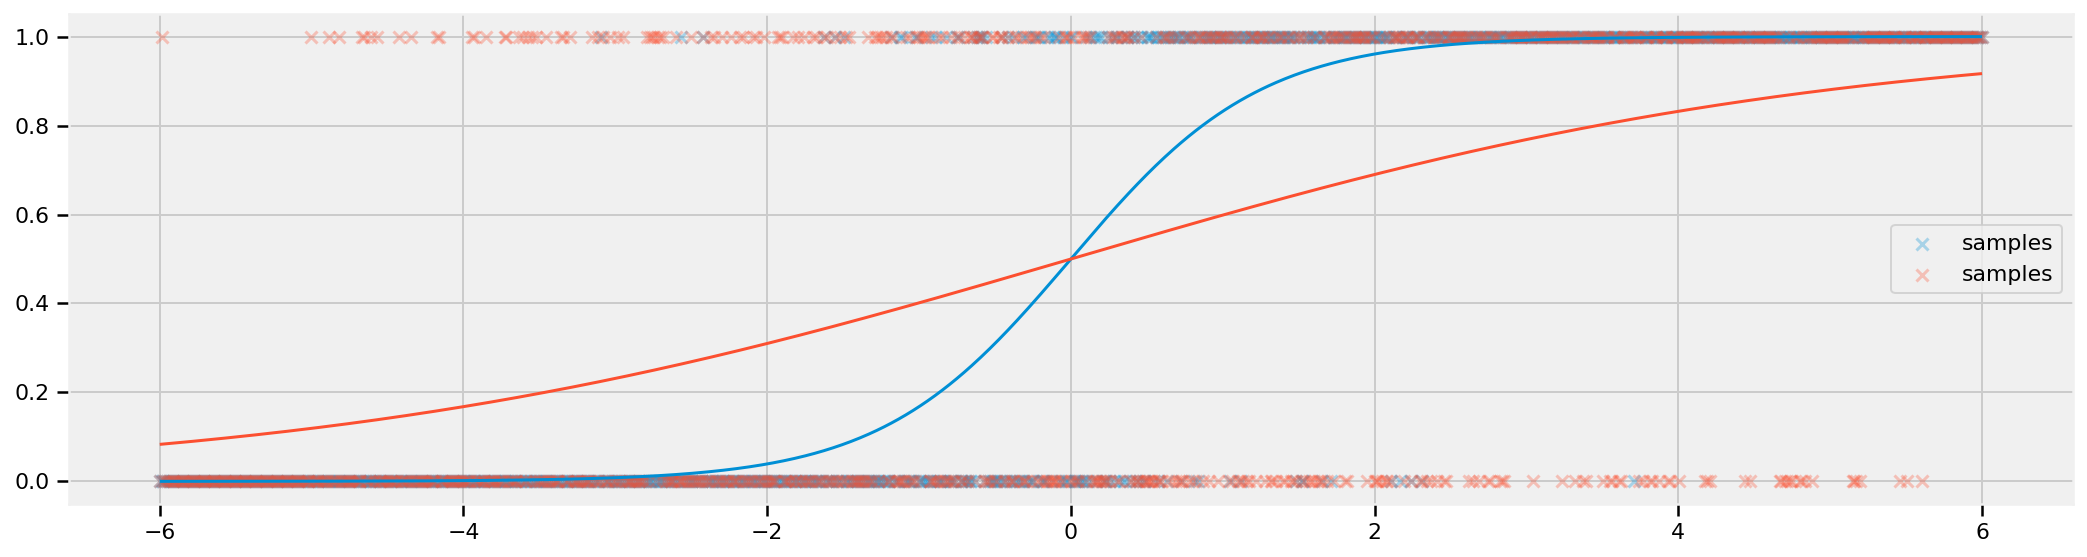

In [9]:
for arm in [0,1]:
  y = []
  p1s = []
  p2s= []
  for i in range(num_data):
    outcome, p1, p2 = customer_reaction(X[i],arm)
    p1s.append(p1)
    p2s.append(p2)
    y.append(outcome)
  
  y = np.array(y).flatten()

  plt.scatter(X,y,alpha = 0.3, marker= 'x', label = 'samples',)
  plt.legend()
  plt.plot(X,p2s)


As we can see, we'd like to choose arm 0 where X is lower than 0 and arm 1 otherwise to get optimal reward (as te function from arm 0 (red) has a higher probability of giving a reward below 0, while arm 1 has a higher probability above 0)

In [0]:
X = shuffle(X)

# Now that we have defined the Problem, let's solve it!

Let's first try to use our non-contextual TS and see how that works out.




In [0]:
class AbstractSolver(object):
    def choose_arm(self):
        """choose an arm to play according to internal policy"""
        raise NotImplementedError
        
    def update(self, arm, reward):
        """ update internal policy to reflect changed knowledge"""
        raise NotImplementedError


In [0]:
class BetaBandit(AbstractSolver):

    def __init__(self, num_options = 2, prior = None):
        """initialize BetaBandit"""
        self.num_options = num_options

        #setting the prior, either uninformative or user generated
        if prior == None:
            self.prior = np.ones(shape=(num_options,2))
        else:
            assert prior.shape == (num_options,2), f"the prior seems to have wrong dimensionality, please conform to (num_options, 2){(num_options,2)}"
            self.prior = prior

        self.trials = np.zeros(shape=(num_options,))
        self.successes = np.zeros(shape=(num_options,))


    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""

        sampled_theta=[]
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
                
            sampled_theta += [dist.rvs()]
      
        return(sampled_theta.index(max(sampled_theta)))    
        
    def update(self,arm,success):
        """update beta-parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""

        # self.successes = self.successes *.99
        if success:
            self.successes[arm] = self.successes[arm]+ 1
            





# Helper functions, non essential


    def choose_arm_and_plot(self):


        sampled_theta = []
        dist_heights = []

      
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
            sample = dist.rvs()
            sampled_theta += [sample]
            dist_heights += [dist.pdf(sample)]

            
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1),alpha=0.8)

                plt.scatter(sampled_theta[i],dist_heights[i], s = 200,label=f'sample drawn from arm {i}')

                plt.fill_between(x,0,y,alpha=1/(self.num_options+1),color=color)
                leg = plt.legend()
                plt.tight_layout    
      
        return(sampled_theta.index(max(sampled_theta)))  


    def plot_betas(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout


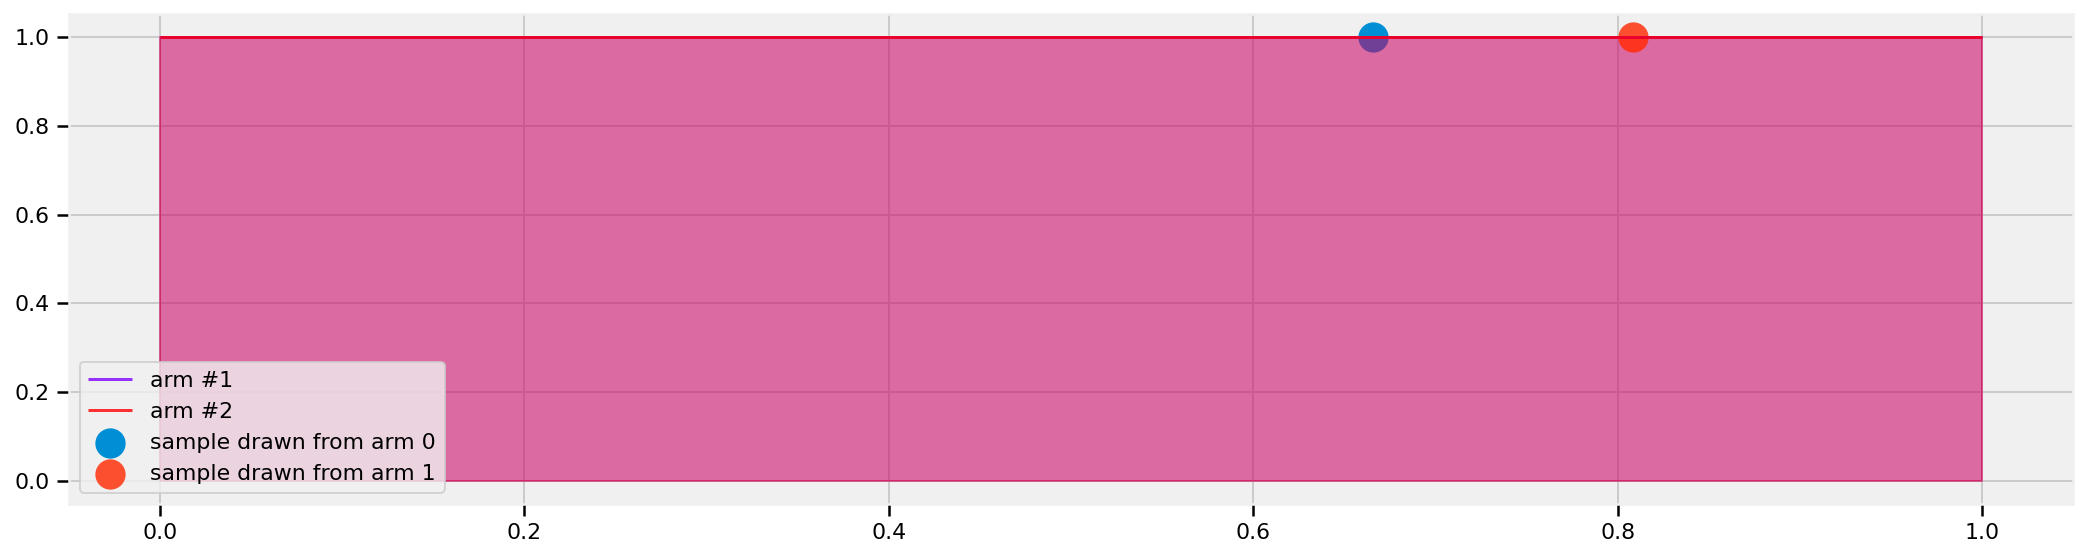

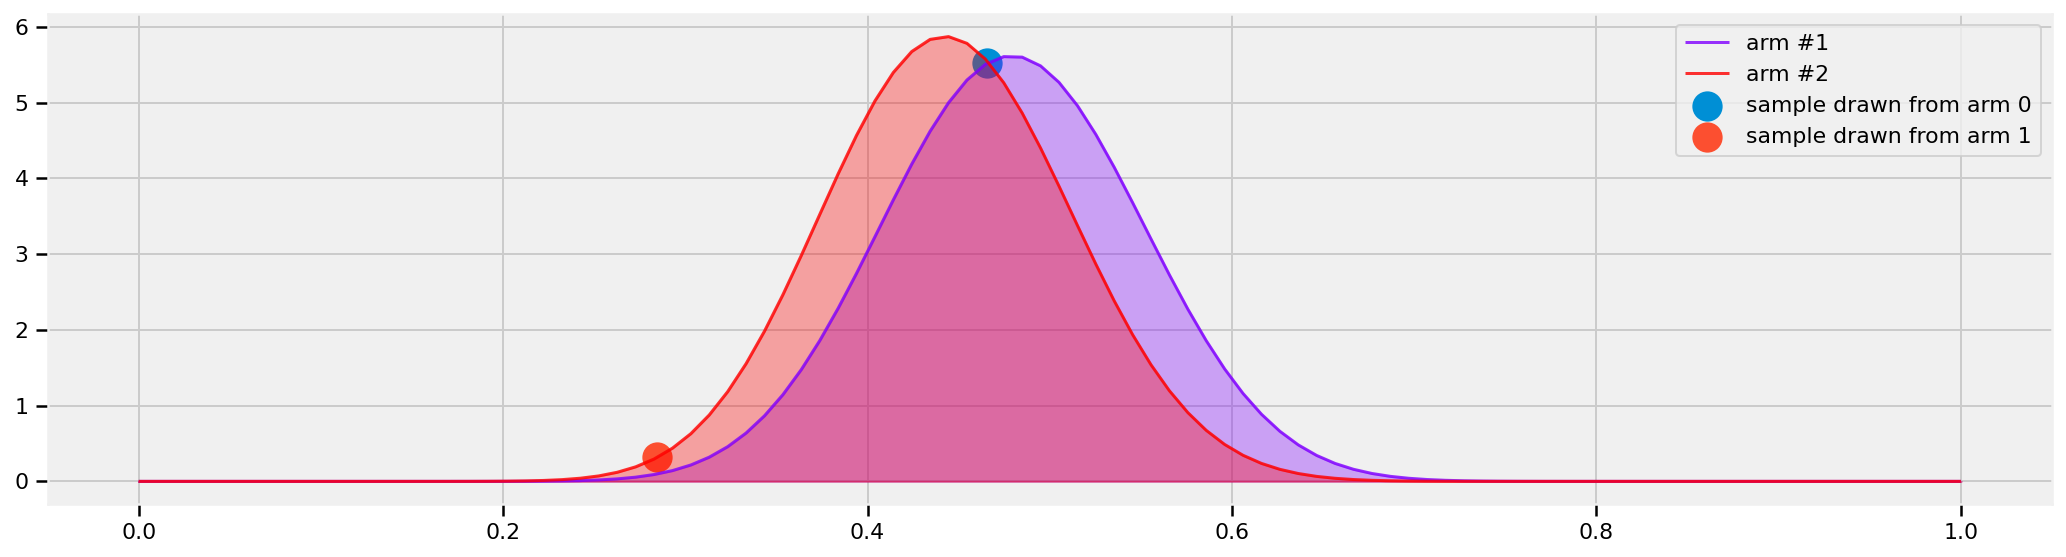

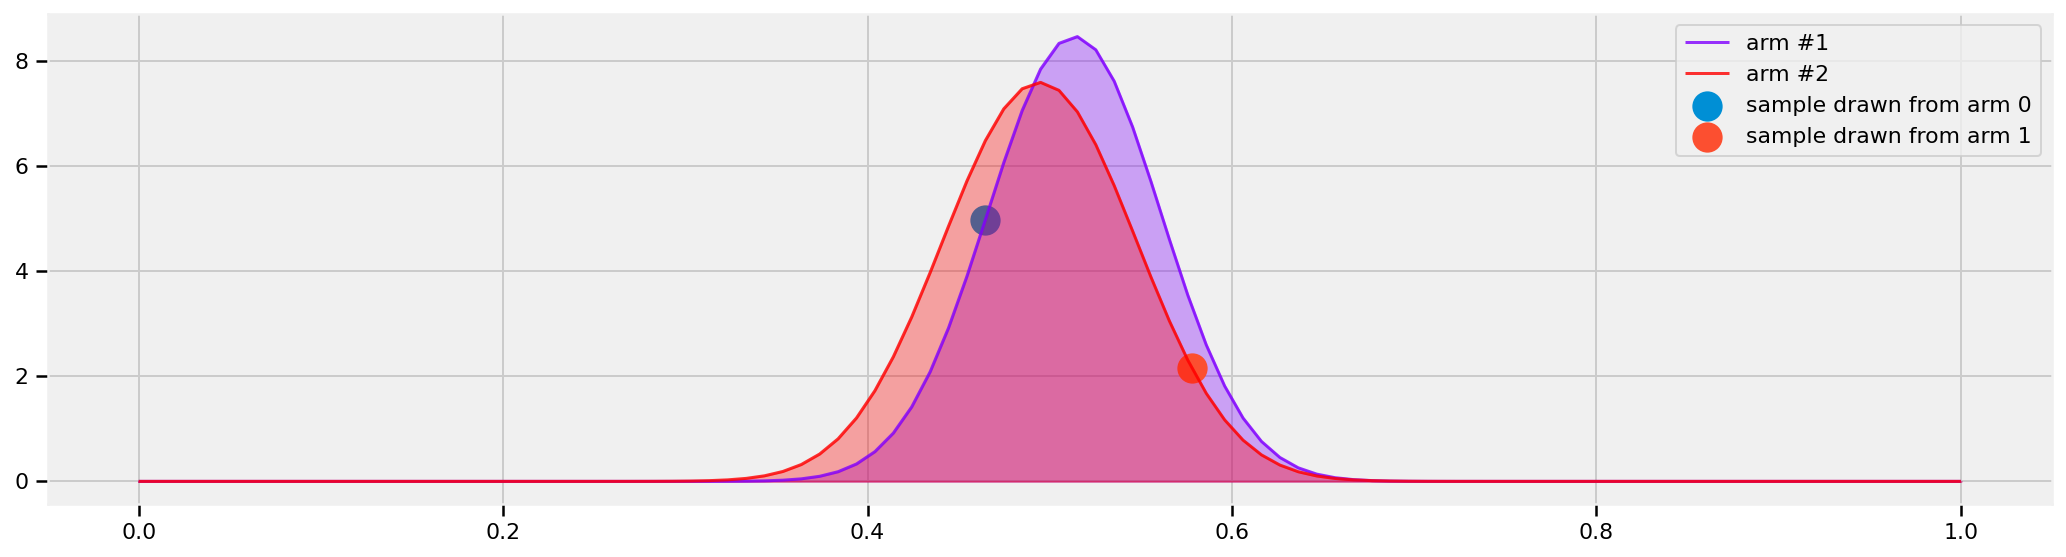

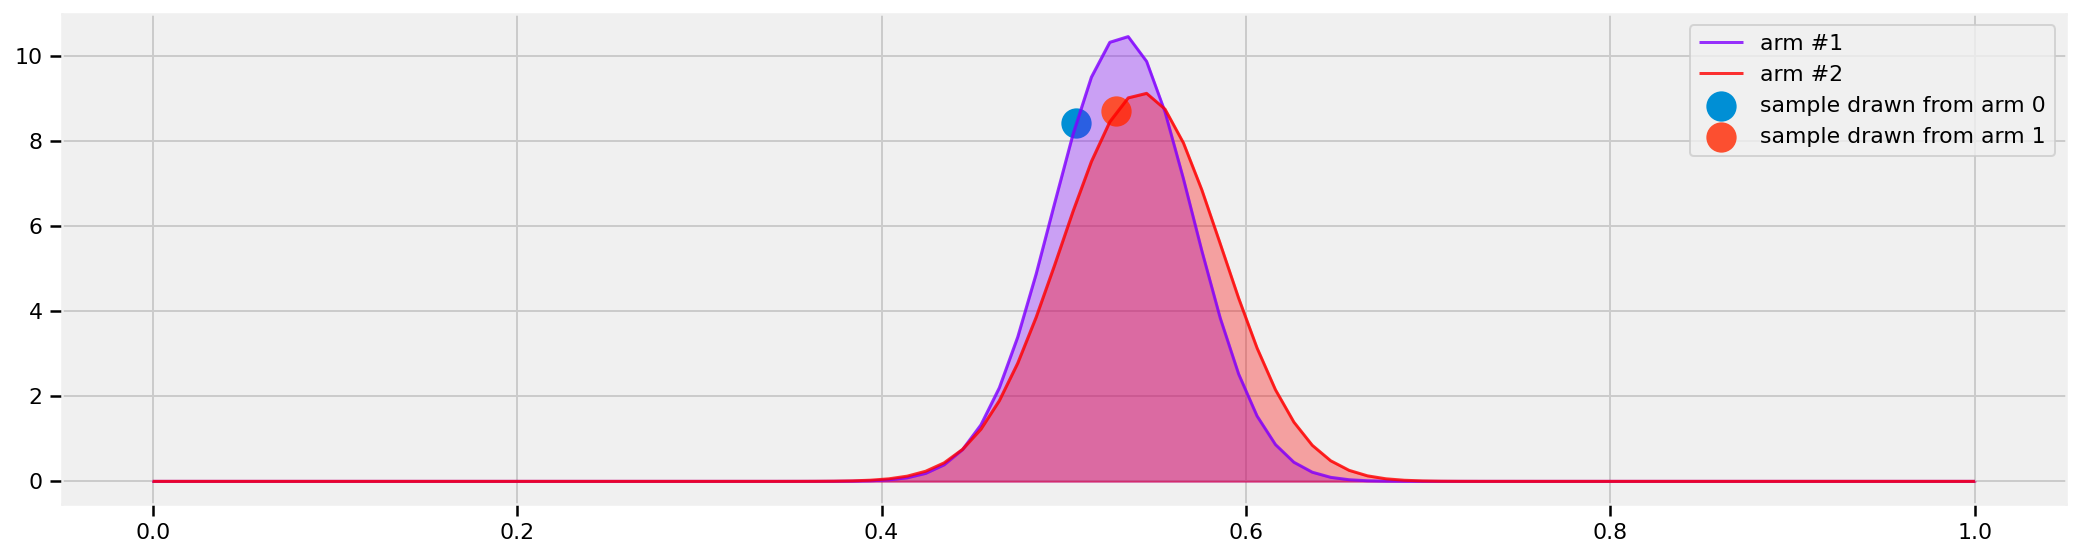

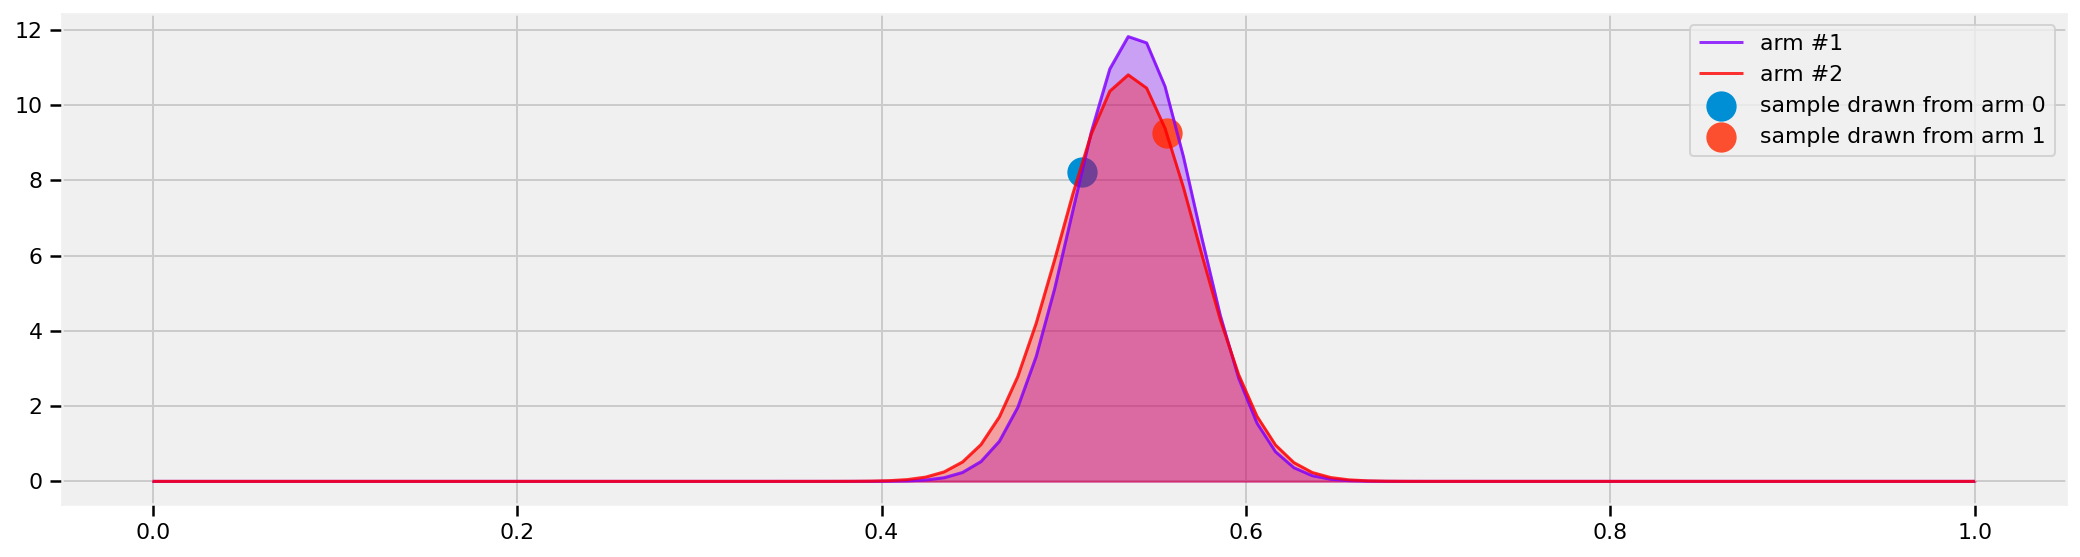

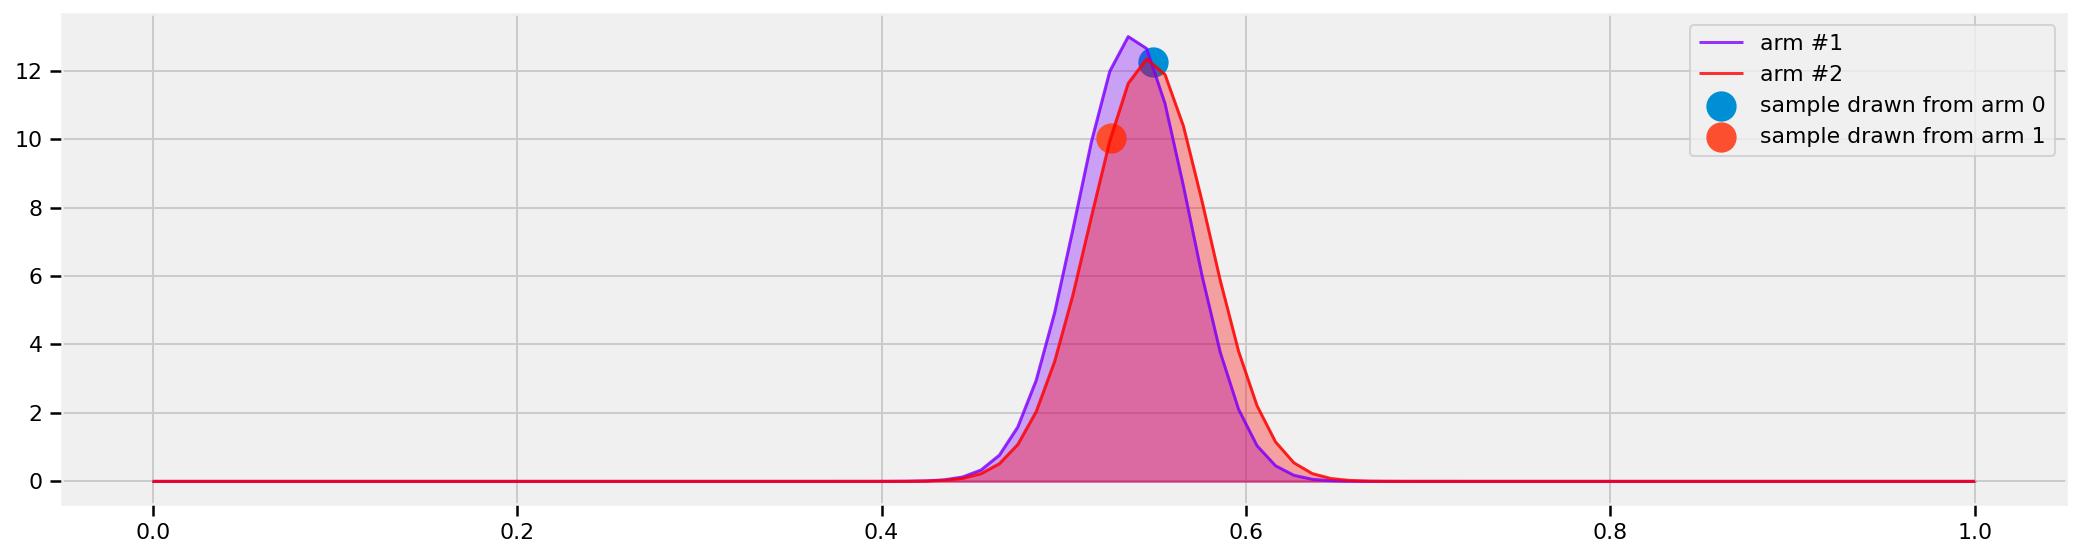

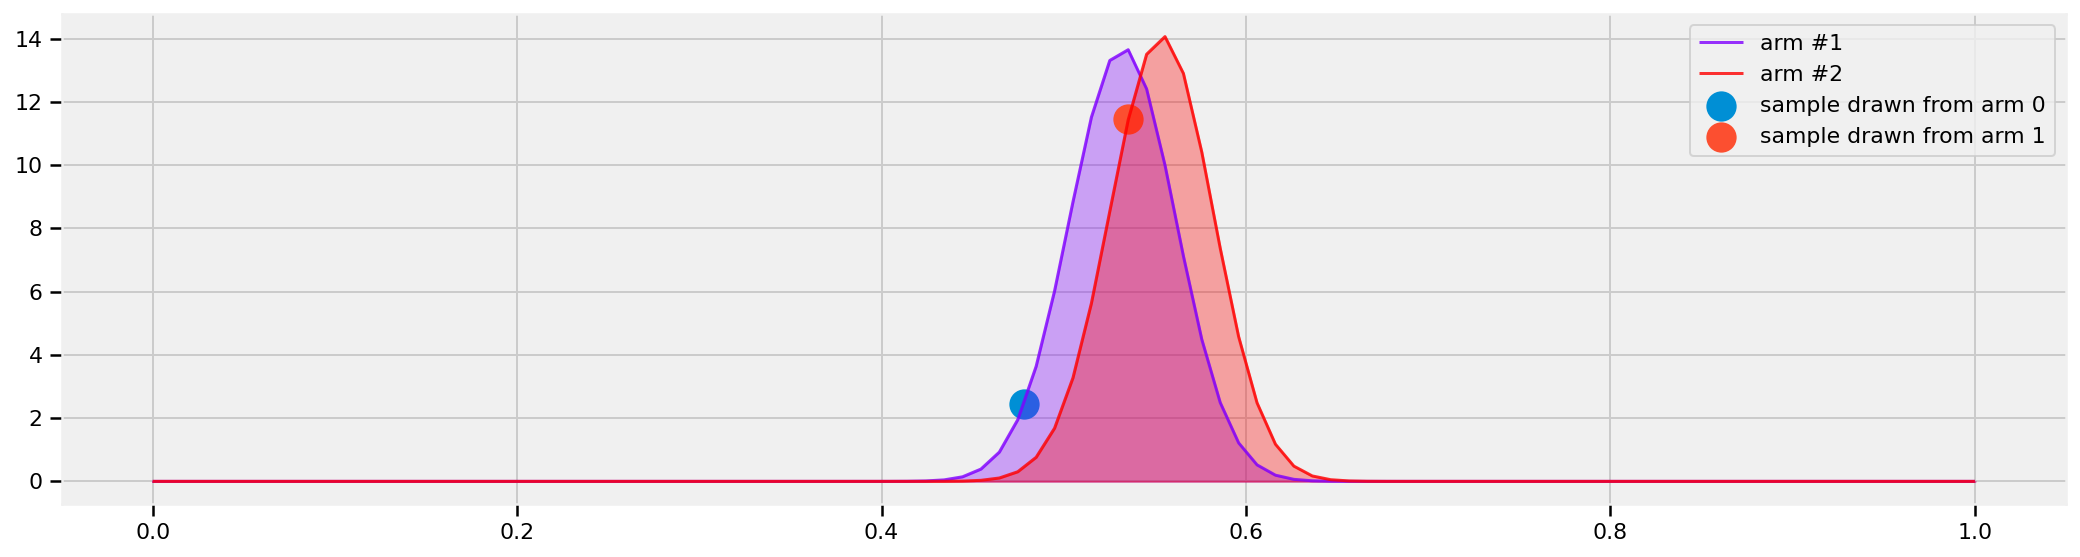

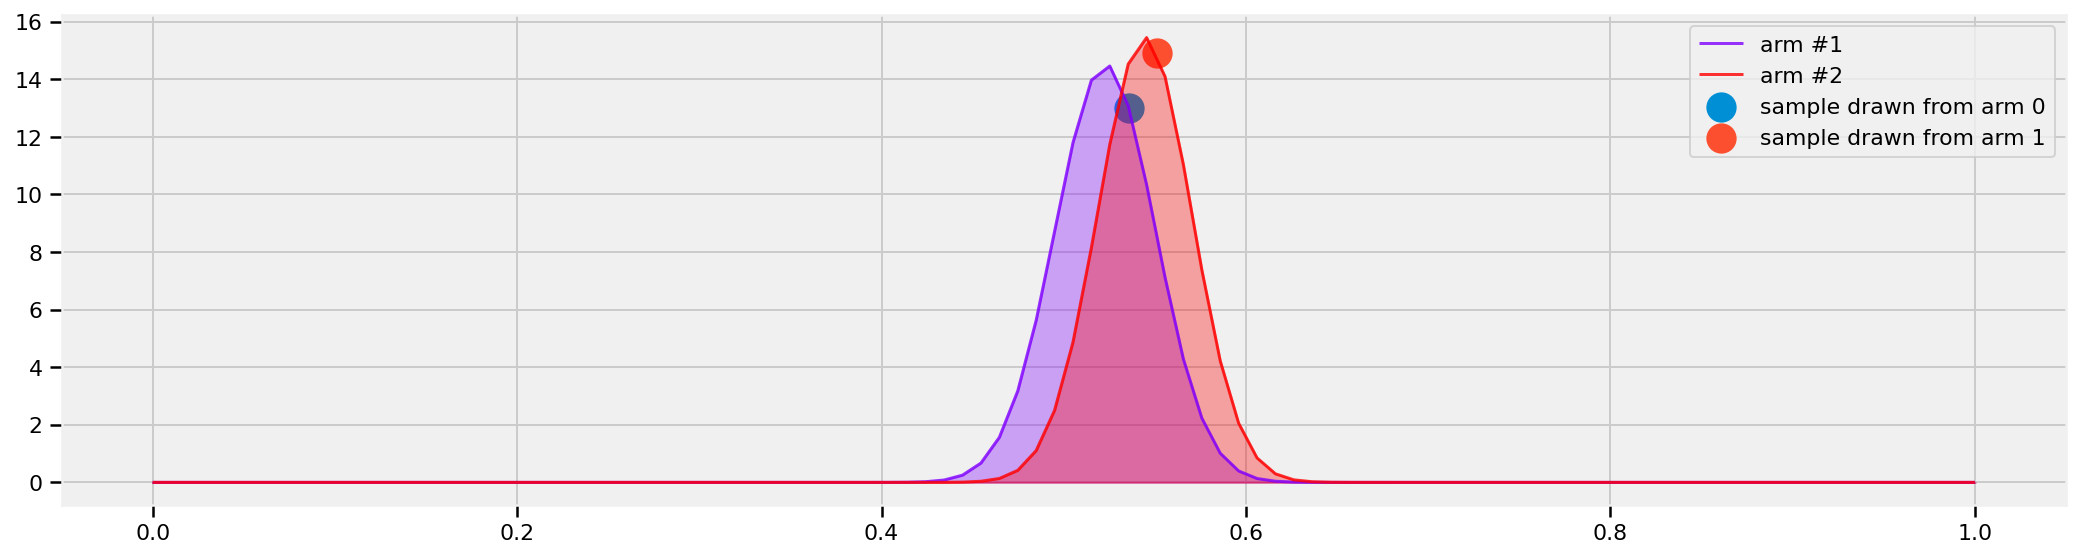

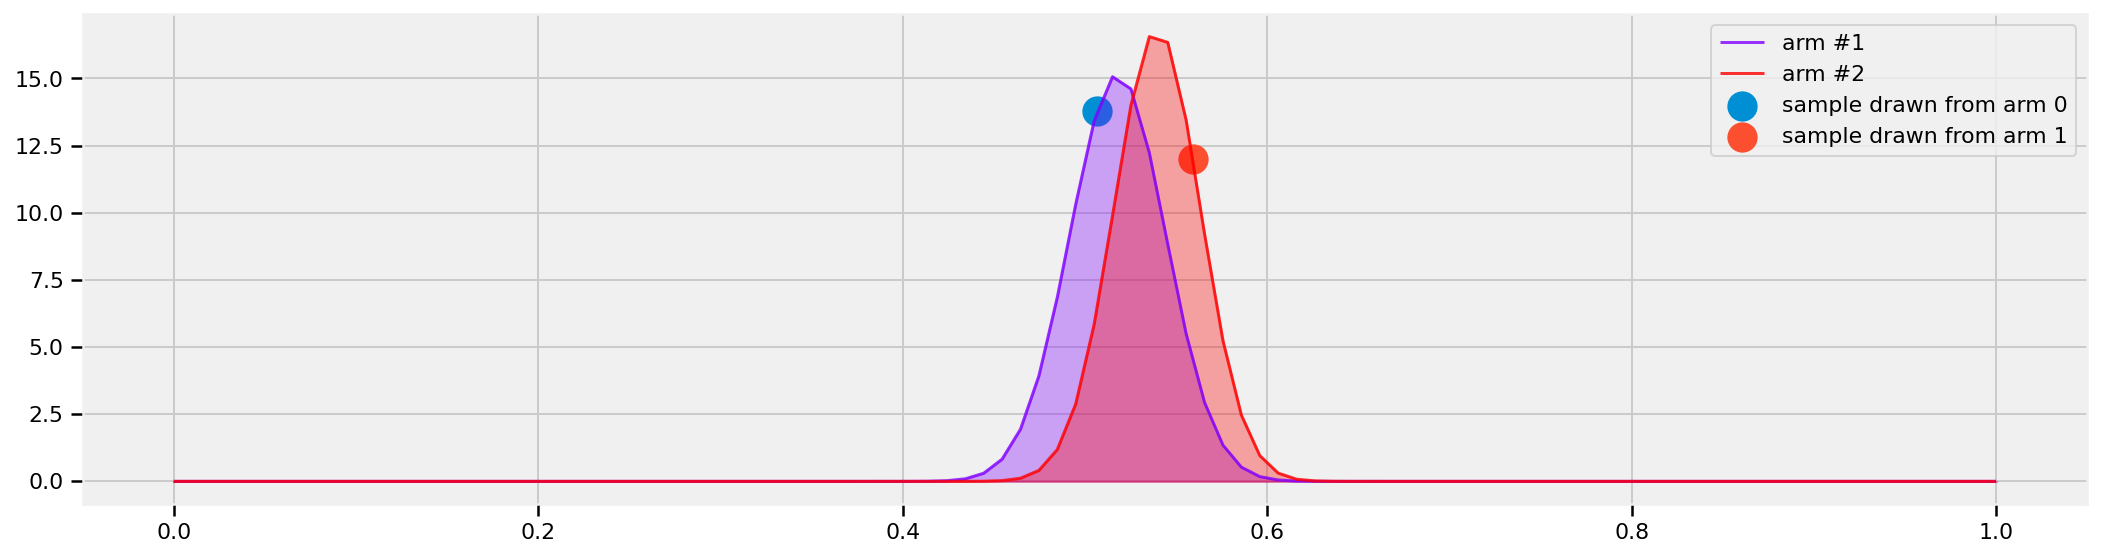

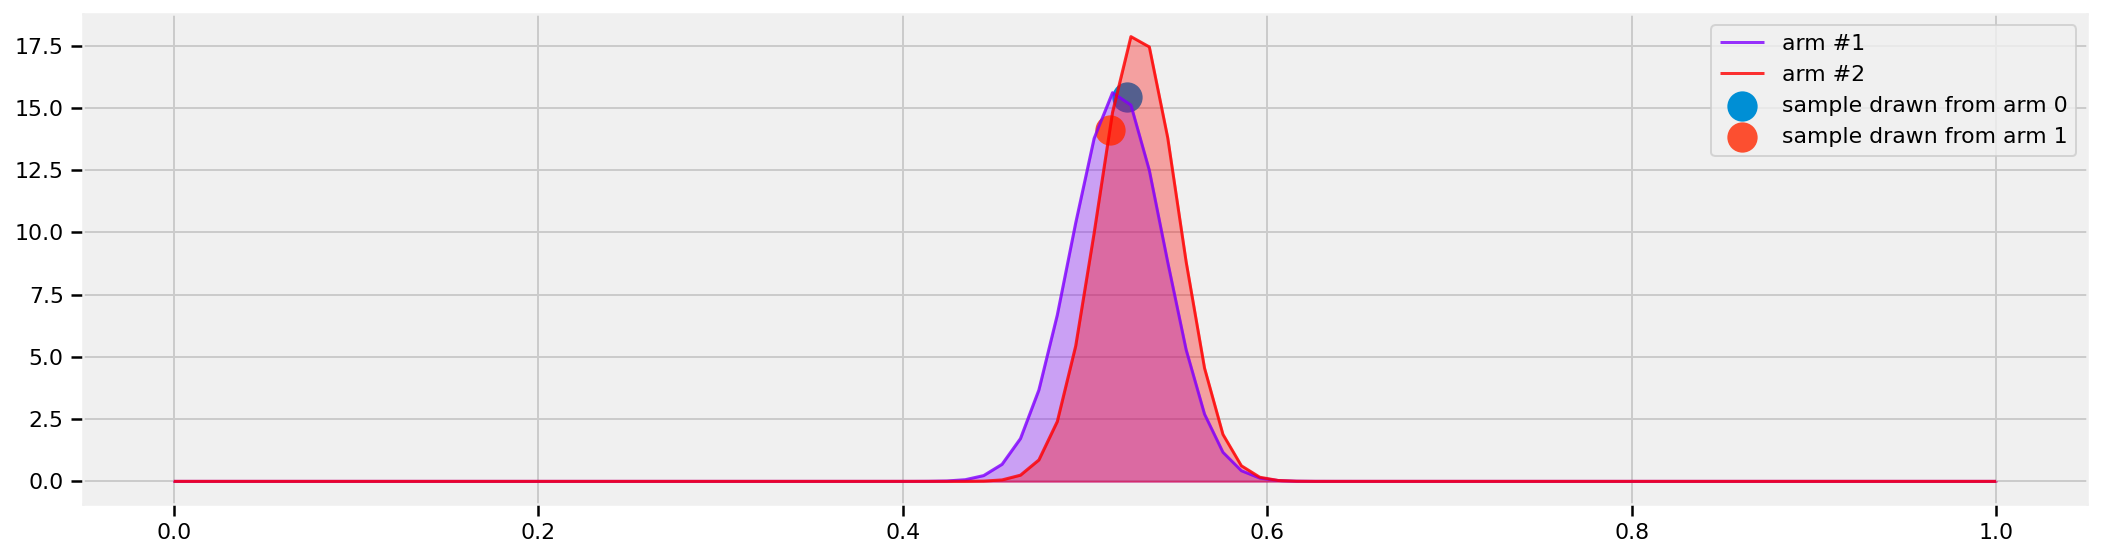

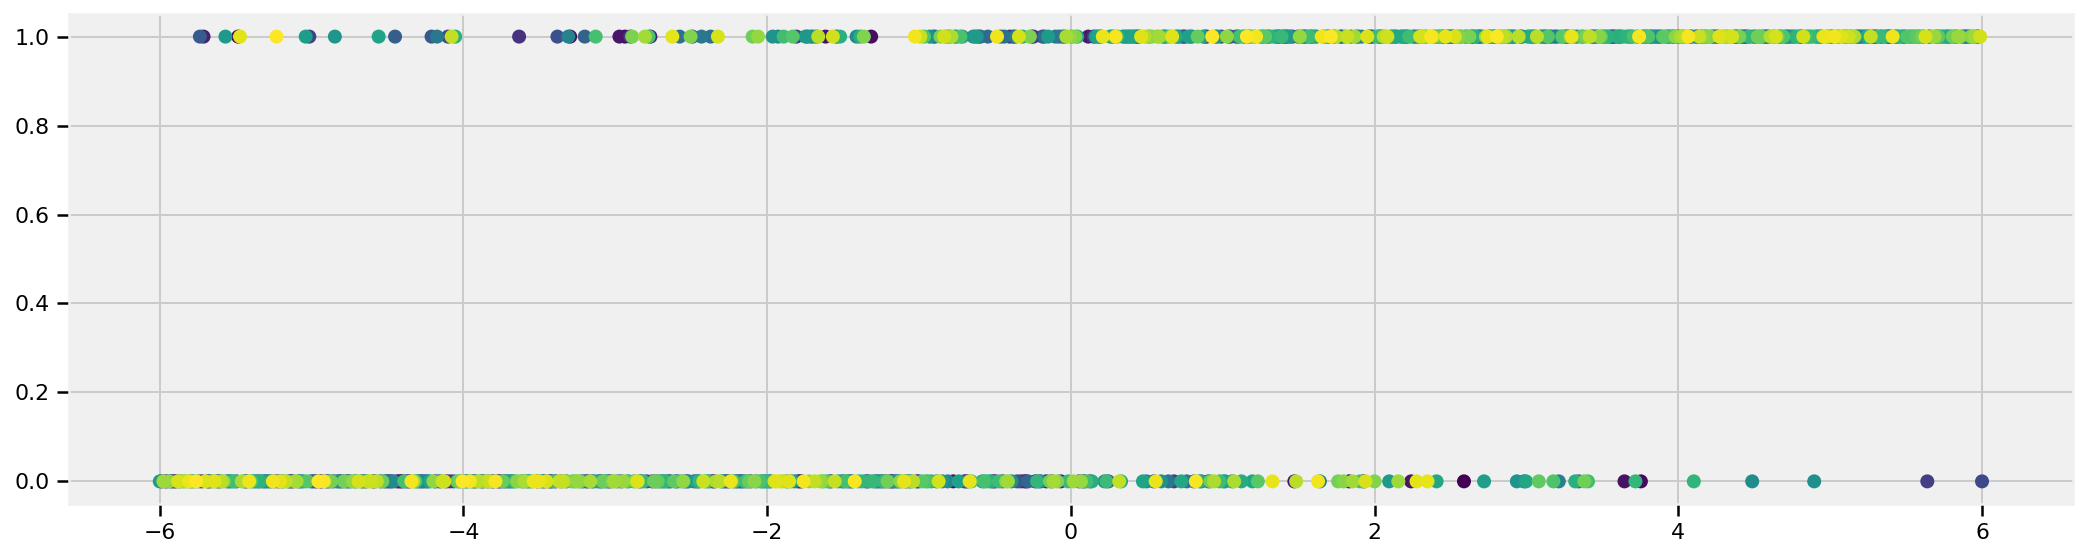

In [36]:
bb = BetaBandit()

y_hat_list = []
best_arms = []

for i in progress_bar(range(num_data)):
  context = X[i]


  if i % (num_data/10) == 0:
    plt.figure()
    arm = bb.choose_arm_and_plot()
  else:
    arm = bb.choose_arm()
  y_hat = customer_reaction(context,arm)[0]
  y_hat_list += [y_hat]
  bb.update(arm, y_hat)
  #if i % num_data/10


plt.figure()
plt.scatter(X,np.array(y_hat_list),c=range(len(y_hat_list)))




# That didn't work very well

That's not surprising, as the average reward when ignoring the context is the same for both arms. Through some random stuff, we managed to get a bit of bias in the right direction, but it's not great.

In [0]:
class AbstractContextualSolver(object):
  def __init__(self, model, num_arms):
    self.model = model
    self.num_arms = num_arms


  def choose_arm(self,context):
    """choose an arm to play according to internal policy"""
    raise NotImplementedError
        
  def update(self, arm, context, reward):
    """ update internal policy to reflect changed knowledge"""
    raise NotImplementedError

We need a distribution to sample from, so we implement bayesian logistic regression

In [0]:
# defining a class for our online bayesian logistic regression
class OnlineLogisticRegression:
    
    # initializing
    def __init__(self, lambda_, alpha, n_dim):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
        return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)


    def observe(self,X,y):
      self.fit(X,y)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
        
        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [0]:
wee_x = np.random.uniform(-6,6,10)
wee_y = np.array([customer_reaction(x,0)[0] for x in wee_x])

In [0]:
# OLR object
online_lr = OnlineLogisticRegression(0.5, 1, 1)
online_lr.fit(wee_x.reshape(-1,1), wee_y)

No handles with labels found to put in legend.


<Figure size 1350x525 with 0 Axes>

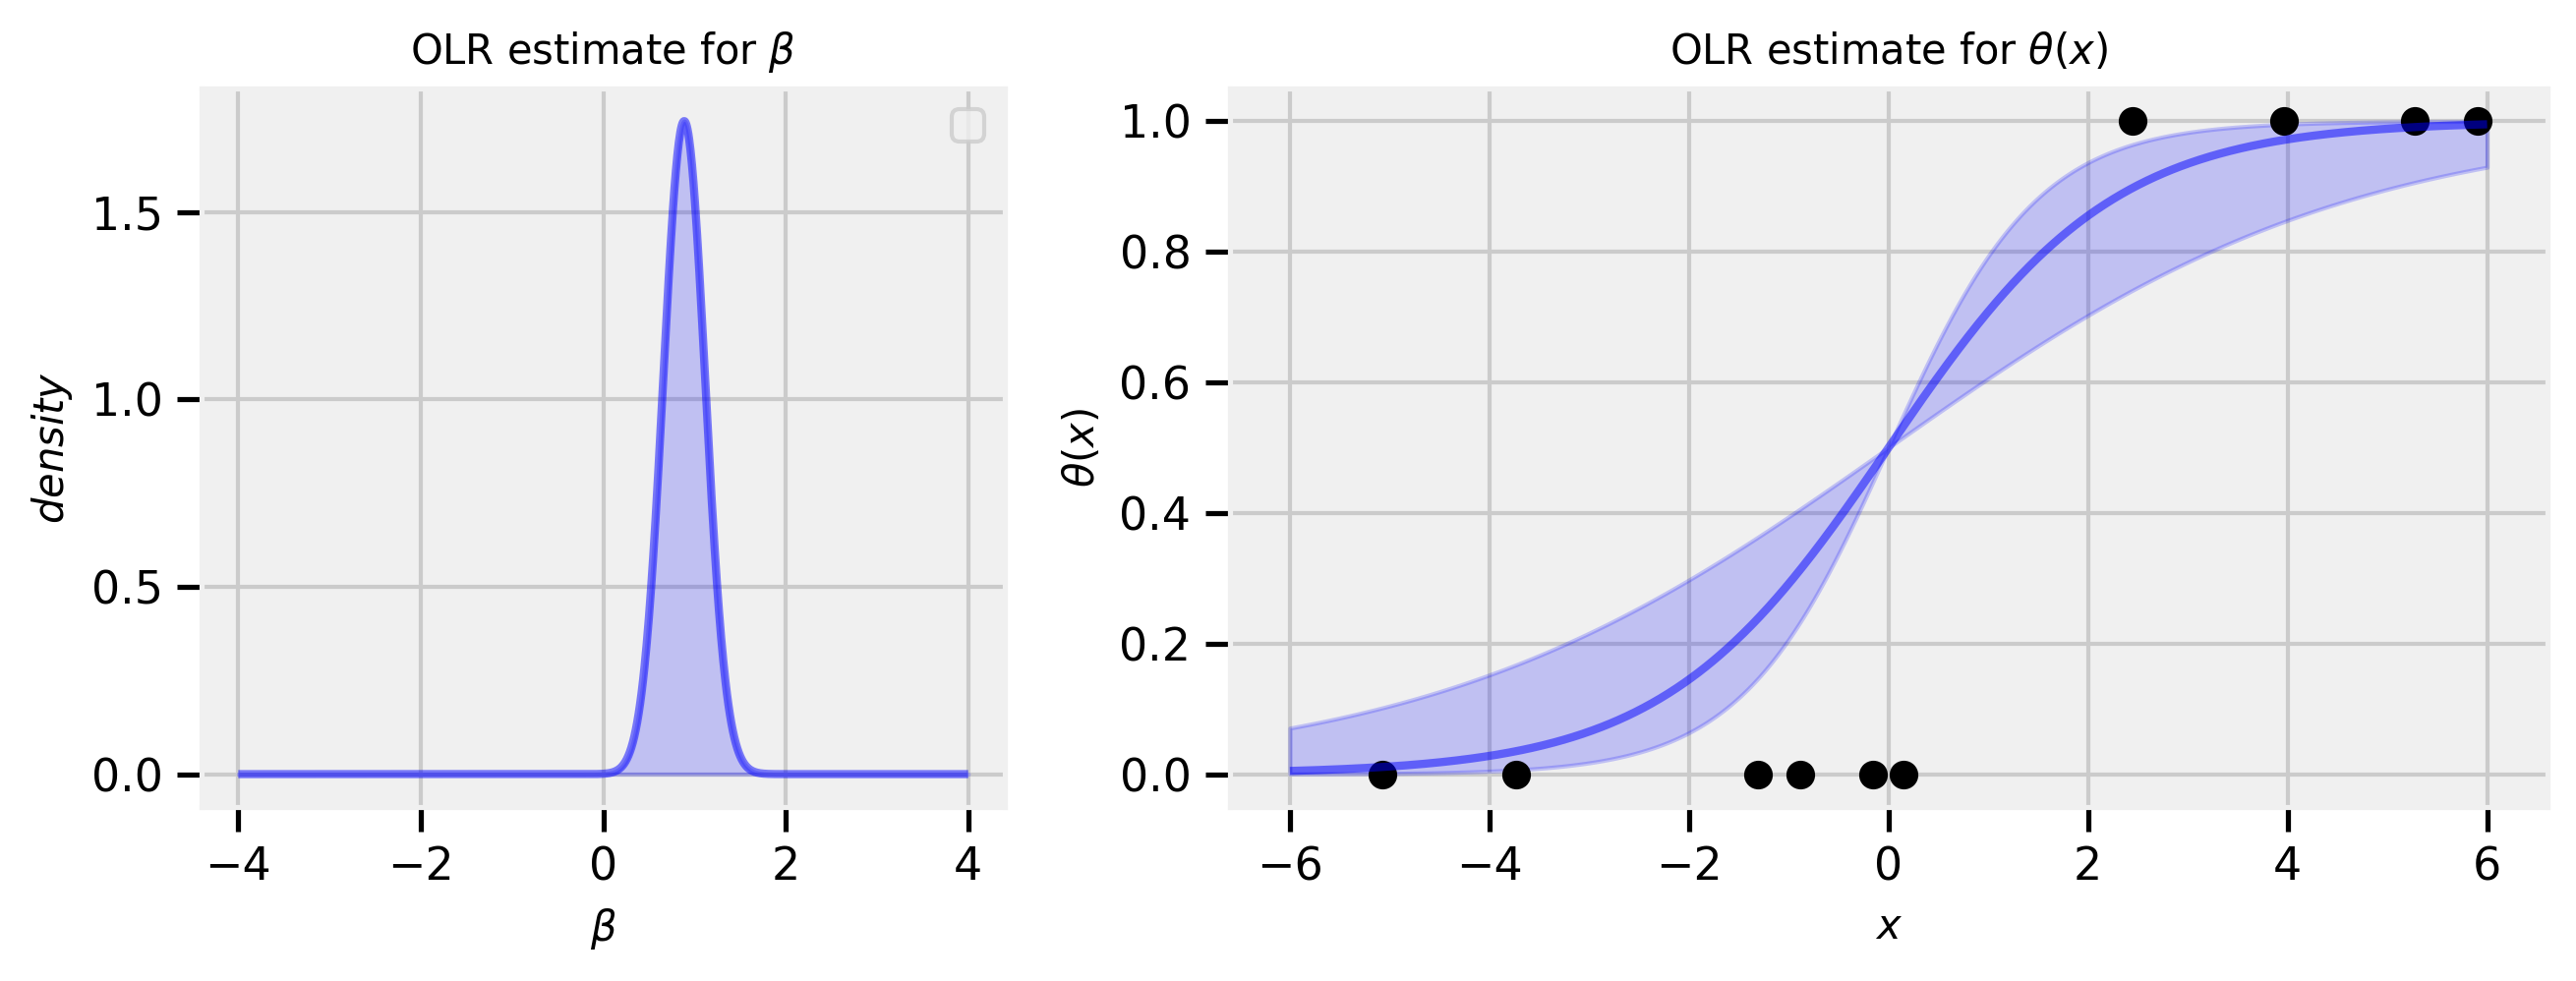

In [41]:
# closing other figures
plt.close('all')
plt.figure(figsize=[9,3.5], dpi=150)

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = stats.norm(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
#ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(wee_x, wee_y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [0]:
# now, we define a class for our policy
class LogisticThompsonSampler(AbstractContextualSolver):

    
    def update(self,arm,context,reward):
      X =  np.atleast_2d(np.append(arm, context))
      reward = np.atleast_2d(reward).T
      self.model.observe(X, reward)
        
    def choose_arm(self,context):
      reward_list = []

      for i in range(self.num_arms):
        arm = i
        X = np.atleast_2d(np.append(arm, context))

        reward_sample = self.model.predict_proba(X)[0][0]
        reward_list += [reward_sample]

      
      return np.argmax(reward_list)        
      


In [0]:
online_lr = OnlineLogisticRegression(0.5, 1, 2)

lts = LogisticThompsonSampler(online_lr,num_arms=2)

In [44]:
lts.choose_arm(1)

0

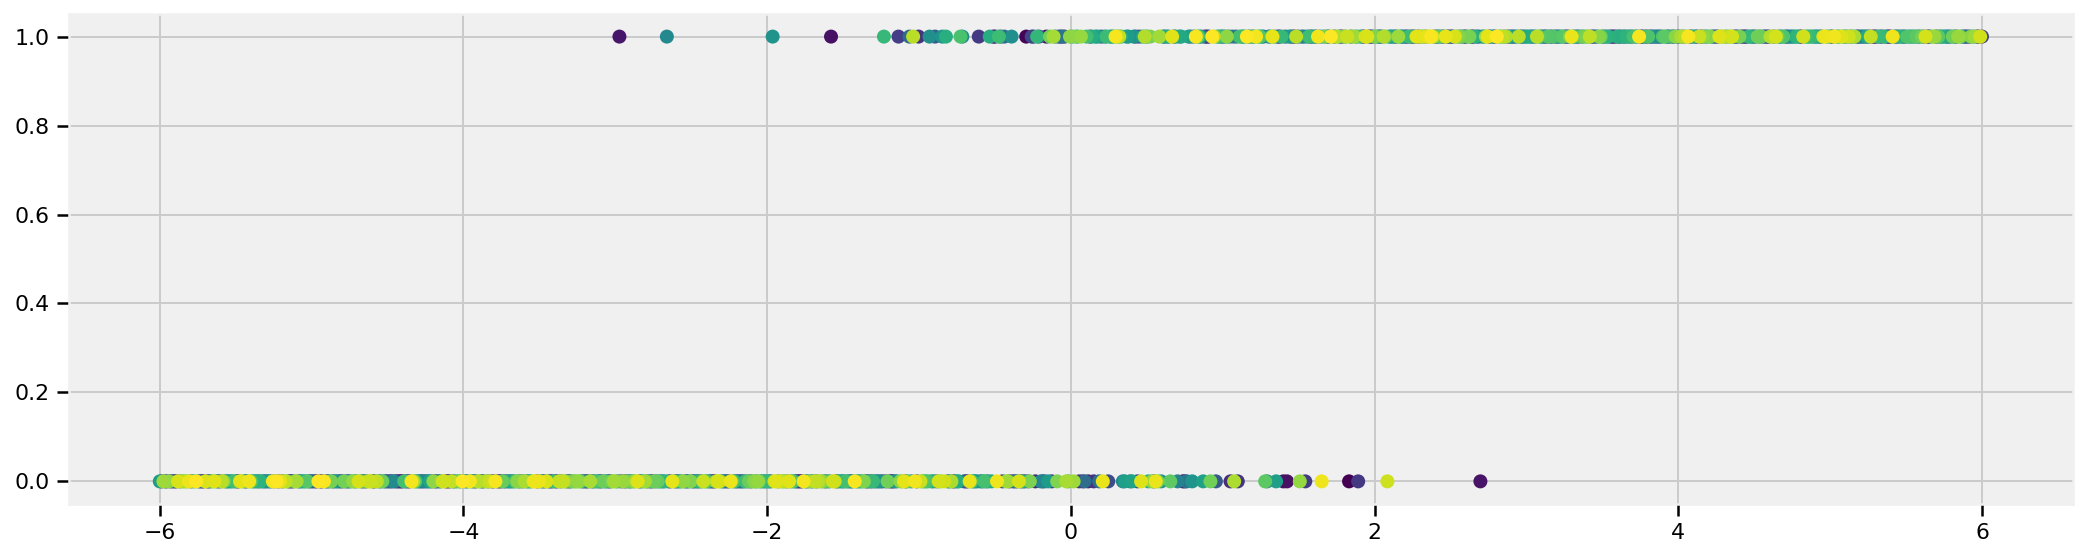

In [45]:
breg = OnlineLogisticRegression(0.5,1,2)
lts = LogisticThompsonSampler(breg,num_arms = 2)


y_hat_list = []
best_arms = []

for i in progress_bar(range(num_data)):
  context = X[i]

  arm = lts.choose_arm(context)
  y_hat = customer_reaction(context,arm)[0]
  y_hat_list += [y_hat]
  lts.update(arm, context, y_hat)
  #best_arms.append(best_arm_chosen(context[i], y_hat))


plt.figure()
plt.scatter(X,np.array(y_hat_list),c=range(len(y_hat_list)))

